# Corpus arborés et parsing - 2024/25

In [252]:
# Checking the environment
!echo $VIRTUAL_ENV
# and...
!which python
!which pip

/home/santiago/data-backup/misc/M1-treebanks-and-parsing/.venv
/home/santiago/data-backup/misc/M1-treebanks-and-parsing/.venv/bin/python
/home/santiago/data-backup/misc/M1-treebanks-and-parsing/.venv/bin/pip


In [253]:
# install spacy model
# https://spacy.io/usage
!python3 -m spacy download fr_core_news_sm
!pip install spacy seaborn
# ou python au lieu de python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 36.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [254]:
with open("frwiki_50.1000.conllu") as file: #file is a TextIOWrapper object.
    data1 = file.readlines() # liste de lignes
    #data = file.read() # chaîne de caractères
    # for line in file:
    #     print(line)

data1[:20]
# data[-20:]

['# global.columns = ID FORM LEMMA UPOS XPOS FEATS HEAD DEPREL DEPS MISC\n',
 '# sent_id = frwiki_50.1000_00001\n',
 '# text = Affaire des caporaux de Souain\n',
 '1\tAffaire\taffaire\tNOUN\t_\tGender=Fem|Number=Sing\t0\troot\t_\t_\n',
 '2-3\tdes\t_\t_\t_\t_\t_\t_\t_\t_\n',
 '2\tde\tde\tADP\t_\t_\t1\tudep\t_\t_\n',
 '3\tles\tle\tDET\t_\tDefinite=Def|Number=Plur|PronType=Art\t4\tdet\t_\t_\n',
 '4\tcaporaux\tcaporal\tNOUN\t_\tGender=Masc|Number=Plur\t2\tcomp:obj\t_\t_\n',
 '5\tde\tde\tADP\t_\t_\t4\tudep\t_\t_\n',
 '6\tSouain\tSouain\tPROPN\t_\t_\t5\tcomp:obj\t_\t_\n',
 '\n',
 '# sent_id = frwiki_50.1000_00002\n',
 "# text = L'affaire des caporaux de Souain, fusillés pour l'exemple, est un des cas parmi les plus flagrants et les plus médiatisés de l'injustice militaire durant la Première Guerre mondiale.\n",
 "1\tL'\tle\tDET\t_\tDefinite=Def|Number=Sing|PronType=Art\t2\tdet\t_\tSpaceAfter=No\n",
 '2\taffaire\taffaire\tNOUN\t_\tGender=Fem|Number=Sing\t14\tsubj\t_\t_\n',
 '3-4\tdes\t_\t_\t_

De nombreuses façons de compter les phrases

In [255]:
# Si le conllu est bien formaté, on peut faire
n_sentences_A = data1.count("\n")
print(f"{n_sentences_A=}")

n_sentences_A=996


In [256]:
# Mais ce n'est pas du toujours le cas, alors...
n_sentences_B = 0
for line in data1:
    if line.startswith("# sent_id"):
        n_sentences_B += 1
print(f"{n_sentences_B=}")

n_sentences_B=996


In [257]:
# On peut séparer les phrases depuis le début

def read_conllu(path):
    """
    Transformer le fichier conllu dans une liste de listes.
    Chaque liste est une phrase, chaque élément est une ligne.
    """
    data = []
    with open(path, encoding="utf-8") as in_stream:
        next(in_stream)
        sent = []
        for line in in_stream:
            if line == "\n":
                data.append(sent)
                sent = []
            else:
                sent.append(line)
    return data

path = "frwiki_50.1000.conllu"
data2 = read_conllu(path)

for lst in data2[:1]:
    print(lst)

n_sentences_C = len(data2)
print(f"{n_sentences_C=}")

['# sent_id = frwiki_50.1000_00001\n', '# text = Affaire des caporaux de Souain\n', '1\tAffaire\taffaire\tNOUN\t_\tGender=Fem|Number=Sing\t0\troot\t_\t_\n', '2-3\tdes\t_\t_\t_\t_\t_\t_\t_\t_\n', '2\tde\tde\tADP\t_\t_\t1\tudep\t_\t_\n', '3\tles\tle\tDET\t_\tDefinite=Def|Number=Plur|PronType=Art\t4\tdet\t_\t_\n', '4\tcaporaux\tcaporal\tNOUN\t_\tGender=Masc|Number=Plur\t2\tcomp:obj\t_\t_\n', '5\tde\tde\tADP\t_\t_\t4\tudep\t_\t_\n', '6\tSouain\tSouain\tPROPN\t_\t_\t5\tcomp:obj\t_\t_\n']
n_sentences_C=996


In [258]:
# On peut vérifier les résultats, même si dans ce cas c'est inutile
assert  n_sentences_A == n_sentences_B and n_sentences_B == n_sentences_C

Un dictionnaire est peut-être la meilleure façon de stocker chaque phrase

In [259]:
# D'autres informations importantes, telles que les métadonnées et les caractéristiques, ne sont pas prises en compte.

def read_conllu(path) :
    """
    Transformer le fichier conllu dans une liste de liste.
    Chaque liste est une phrase, chaque token est un dictionnaire.
    Certains informations importantes, telles que les métadonnées et les caractéristiques, ne sont pas prises en compte.
    """
    data = []

    with open(path, encoding="utf-8") as in_stream:
        sent = []
        for line in in_stream:
            line = line.strip()
            columns = line.split("\t")

            if columns[0].startswith("#"):
                continue
            if "-" in columns[0]:
                continue
            if columns[0]: # càd, s'il n'est pas vide
                sent.append({
                    "idx" : columns[0],
                    "form" : columns[1],
                    "lemma" : columns[2],
                    "upos" : columns[3],
                    "head" : columns[6],
                    "deprel" : columns[7]})
            else:
                data.append(sent)
                sent = []

    return data

path = "frwiki_50.1000.conllu"
data = read_conllu(path)
data[0]

[{'idx': '1',
  'form': 'Affaire',
  'lemma': 'affaire',
  'upos': 'NOUN',
  'head': '0',
  'deprel': 'root'},
 {'idx': '2',
  'form': 'de',
  'lemma': 'de',
  'upos': 'ADP',
  'head': '1',
  'deprel': 'udep'},
 {'idx': '3',
  'form': 'les',
  'lemma': 'le',
  'upos': 'DET',
  'head': '4',
  'deprel': 'det'},
 {'idx': '4',
  'form': 'caporaux',
  'lemma': 'caporal',
  'upos': 'NOUN',
  'head': '2',
  'deprel': 'comp:obj'},
 {'idx': '5',
  'form': 'de',
  'lemma': 'de',
  'upos': 'ADP',
  'head': '4',
  'deprel': 'udep'},
 {'idx': '6',
  'form': 'Souain',
  'lemma': 'Souain',
  'upos': 'PROPN',
  'head': '5',
  'deprel': 'comp:obj'}]

Compter le nombre des tokens et des lemmes

In [260]:
# Nombre de tokens
n_tokens = 0
for sentence in data:
    n_tokens += len(sentence)
print(n_tokens)

23127


In [261]:
# 🚧 Quelle est la longueur moyenne d'une phrase dans le corpus ?
n_tokens / len(data)

23.21987951807229

In [262]:
# Combien y a-t-il de tokens différents ?
uniq_tokens = set()
for sentence in data:
    for tk in sentence:
        uniq_tokens.add(tk['form'])

print(f"{len(uniq_tokens)=}")

len(uniq_tokens)=4583


In [263]:
# Combien y a-t-il de lemmes différents ?
uniq_lemma = set()
for sentence in data:
    for lemma in sentence:
        uniq_lemma.add(lemma['lemma'])

print(f"{len(uniq_lemma)=}")

len(uniq_lemma)=3437


In [264]:
# Combien y a-t-il de lemmes différents ? Réponse avec une liste en compréhension  
uniq_lemmas = set([tk['lemma'] for sentence in data for tk in sentence])
print(f"{len(uniq_lemmas)=}")

len(uniq_lemmas)=3437


Maintenant, les compter pour de vrai

In [265]:
# Récupérer la liste de tous tokens

lemmas = []
for sentence in data:
    for tk in sentence:
        if tk['upos'] != "PUNCT":
            lemmas.append(tk['lemma'])

# Avec une liste en compréhension  
#tokens = [tk['token'] for sentence in data for tk in sentence]

counter = dict()
for l in lemmas:
    if l in counter:
        counter[l] += 1
    else:
        counter[l] = 1

# On ordonne le dictionnaire et on obtient une liste de tuples ordonnés
sorted_lemmas = sorted(counter.items(), key=lambda item : item[1], reverse=True)
sorted_lemmas[:5]

[('le', 2474), ('de', 2048), ('à', 519), ('un', 472), ('et', 387)]

In [266]:
# Avec la meilleure bibliothèque de Python
from collections import Counter

counter = Counter(lemmas)
sorted_lemmas = sorted(counter.items(), key=lambda item : item[1], reverse=True)
sorted_lemmas[:5]

[('le', 2474), ('de', 2048), ('à', 519), ('un', 472), ('et', 387)]

In [267]:
!pip install seaborn

<Axes: >

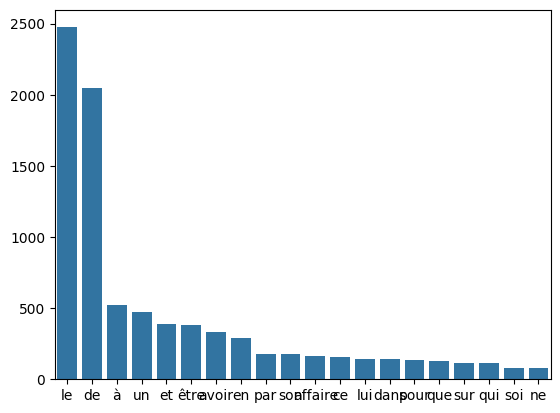

In [268]:
import seaborn as sns

freq = []
labels = []
for lemma in sorted_lemmas[:20]:
    freq.append(lemma[0])
    labels.append(lemma[1])

sns.barplot(x=freq, y=labels)

<Axes: >

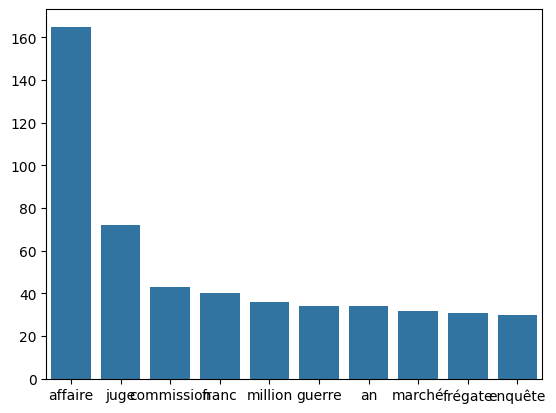

In [279]:
# Représentez graphiquement tous les noms et leur fréquence avec un barplot
nouns = []
for sentence in data:
    for tk in sentence:
        if tk['upos'] == "NOUN":
            nouns.append(tk['lemma'])

counter_nouns = sorted(Counter(nouns).items(), key = lambda x: x[1], reverse=True)
freq = []
labels = []
for lemma in counter_nouns[:10]:
    freq.append(lemma[0])
    labels.append(lemma[1])

sns.barplot(x=freq, y=labels)

<Axes: >

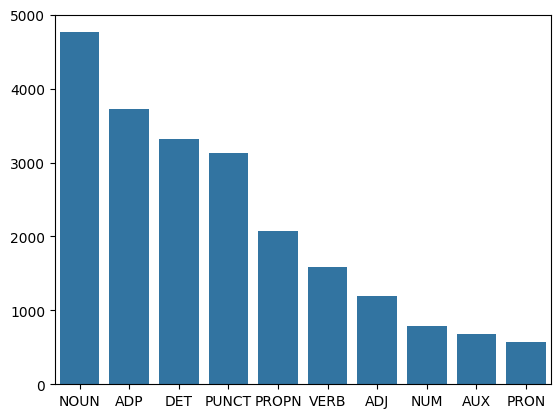

In [274]:
# Représentez la distribution de partie du discours avec un barplot
pos = []
for sentence in data:
    for tk in sentence:
        pos.append(tk['upos'])

counter_upos = sorted(Counter(pos).items(), key = lambda x: x[1], reverse=True)
freq = []
labels = []
for pos in counter_upos[:10]:
    freq.append(pos[0])
    labels.append(pos[1])

sns.barplot(x=freq, y=labels)

In [271]:
# Combien y a-t-il des adjectifs avant et après leur nom?

adj_position = {"before" : 0, "after": 0}

# for sentence in data:
#     for token_i in sentence:
#         if token_i['upos'] == "NOUN":
#             for token_j in sentence:
                # À compléter, réponse en bas...

<Axes: >

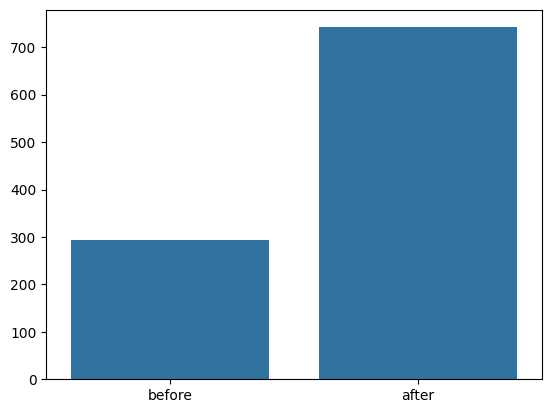

In [272]:
adj_position = {"before" : 0, "after": 0}

for sentence in data:
    for token_i in sentence:
        if token_i['upos'] == "NOUN":
            for token_j in sentence:
                if token_j['head'] == token_i['idx'] and token_j['upos'] == "ADJ":
                    if int(token_i['idx']) < int(token_j['idx']):
                        adj_position['after'] += 1
                    else:
                        adj_position['before'] += 1

sns.barplot(adj_position)

## Partie 2

Et si je veux tagger et analyser syntaxiquement un texte ?

In [273]:
# Une segmentation très naive
with open("conte.txt", encoding="utf-8") as file:
    text = file.read()
    
#sentences = [sent.strip() for sent in text.split(".")]
sentences = []
for sent in text.split('.'):
    sent_stripped = sent.strip()
    if sent_stripped:
        sentences.append(sent_stripped)
sentences[:3]

['Alors que la ville de Hamelin est envahie par les rats et que les habitants meurent de faim, un joueur de flûte inconnu arrive dans la ville et se présente comme un dératiseur',
 "Le maire de Hamelin promet au joueur de flûte une prime de mille écus pour débarrasser la commune des rats qui l'infestent",
 "L'homme prend sa flûte et, par sa musique, attire les rats qui le suivent jusqu'à la Weser, la rivière qui arrose la ville, où ils se noient"]

In [ ]:
# Encore mieux avec spaCy
import spacy
from spacy import displacy
nlp = spacy.load("fr_core_news_sm")
# Je parse tout le text au même temps
doc = nlp(text)

In [ ]:
list(doc.sents)

In [ ]:
for sent in doc.sents:
    print(f"la racine est {sent.root.text}")
    for token in sent:
        print(token.text, token.pos_, token.morph, token.morph, token.lemma_, token.dep_)
    
    # pour trouver les enfants
    for child in token.children:
        print(token, child.text)

# upos = [(token.text, token.pos_) for token in doc]
# print(upos)

In [ ]:
#dir(doc)

In [ ]:
for token in list(doc.sents)[0][:3]:
    print(f"token : {token.text}\t deprel : {token.dep_}\t token_head : {token.head.text}")

In [ ]:
# Trouver les verbes avec un sujet    
verbs = list()
for possible_subject in doc:
    if possible_subject.dep_ == "nsubj" and possible_subject.head.pos_ == "VERB":
        verbs.append(possible_subject.head)
print(verbs)

In [ ]:
displacy.render(list(doc.sents)[0], style='dep')

Exos

In [ ]:
# Analysez avec SpaCy les phrases du conte Le Joueur de flûte de Hamelin. 
# a. Combient y a-t-il de mots ?
# b. Quelle est la phrase la plus longue ?
# c. Quelle est la longueur moyenne de phrases?
# d. Quel est le mot le plus longue ?
# e. Combient y a-t-il de verbes ?
# f. Plottez avec un barplot les dix mots les plus fréquents.

In [ ]:
# Encore à vous...
# a. Quelle est la distribution de dépendances à gauche et à droite? Check spaCy API https://spacy.io/api/token
# b. Quelles sont les dépendances qui, dans au moins 90 % des cas, vont à gauche ? 
# c. Quel est le nombre maximal de dépendants pour un nœud ?
# d. Y a-t-il des dépendances non projectives ?